In [2]:
import numpy as np
import scipy.spatial as sp
import networkx as nx

def build_voronoi_graph(points):
    """
    Construye el grafo planar dual del diagrama de Voronoi:
    nodos = vértices de Voronoi (grado típico ~3),
    aristas = segmentos del diagrama.
    """
    vor = sp.Voronoi(points)
    G = nx.Graph()
    # añadir vértices
    for i, v in enumerate(vor.vertices):
        G.add_node(i, pos=tuple(v))
    # añadir aristas (solo las finitas)
    for (p,q), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        v1, v2 = ridge_vertices
        if v1>=0 and v2>=0:
            G.add_edge(v1, v2)
    return G

def orient_graph_downward(G):
    """
    Dado un grafo planar con posiciones 'pos',
    orienta cada arista de mayor y a menor y.
    Devuelve un DiGraph acíclico.
    """
    DG = nx.DiGraph()
    for u,v in G.edges():
        y1 = G.nodes[u]['pos'][1]
        y2 = G.nodes[v]['pos'][1]
        if y1 > y2:
            DG.add_edge(u,v)
        elif y2 > y1:
            DG.add_edge(v,u)
        # si y1==y2, romper al azar
        else:
            if np.random.rand()<0.5:
                DG.add_edge(u,v)
            else:
                DG.add_edge(v,u)
    return DG

def monte_carlo_spatial(N_points=2000, seed=123):
    np.random.seed(seed)
    # 1) generar puntos y grafo Voronoi
    pts = np.random.rand(N_points,2)
    G = build_voronoi_graph(pts)
    DG = orient_graph_downward(G)
    # 2) quedarnos solo con nodos de grado total (in+out)==3
    DG = DG.subgraph([n for n in DG if DG.in_degree(n)+DG.out_degree(n)==3]).copy()
    # 3) topological sort y asignación de flujos
    topo = list(nx.topological_sort(DG))
    # inicializar flujos en nodos de la frontera superior (y > 0.95)
    flow_node = {n: 0.0 for n in topo}
    for n in topo:
        y = G.nodes[n]['pos'][1]
        if y > 0.95:
            flow_node[n] = 1.0
    # 4) Propagar: en cada nodo, repartir su flow_node[n] uniformemente
    #    entre sus aristas salientes
    flow_edge = []
    for n in topo:
        F = flow_node[n]
        outs = list(DG.successors(n))
        if len(outs)==0: continue
        ω = np.random.rand(len(outs))
        ω = ω/ω.sum()
        for frac, m in zip(ω, outs):
            f = frac * F
            flow_edge.append(f)
            flow_node[m] += f

    # 5) estadísticas
    flows = np.array(flow_edge)
    mu   = flows.mean()
    var  = flows.var()
    return mu, var, mu**2/var

if __name__=="__main__":
    mu,var,ratio = monte_carlo_spatial(N_points=3000, seed=42)
    print(f"Mean μ        = {mu:.6f}")
    print(f"Variance Var  = {var:.6f}")
    print(f"μ²/Var        = {ratio:.6f}")


Mean μ        = 3.952552
Variance Var  = 20.277073
μ²/Var        = 0.770460


/home/jose/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Mean μ        = 3.952552
Variance Var  = 20.277073
μ²/Var        = 0.770460


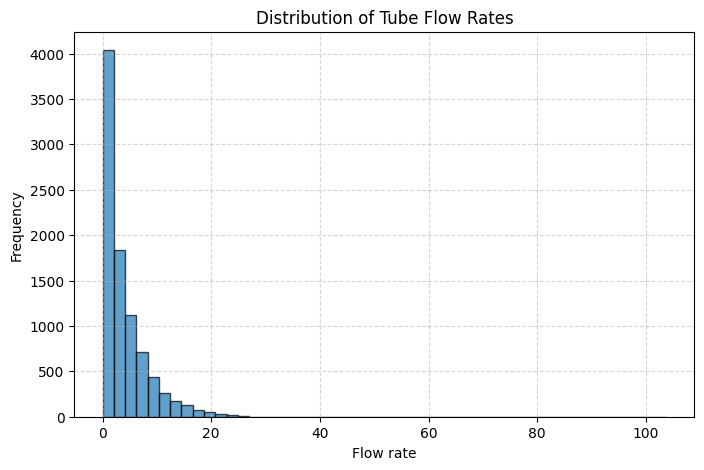

In [3]:
import numpy as np
import scipy.spatial as sp
import networkx as nx
import matplotlib.pyplot as plt

def build_voronoi_graph(points):
    vor = sp.Voronoi(points)
    G = nx.Graph()
    for i, v in enumerate(vor.vertices):
        G.add_node(i, pos=tuple(v))
    for ridge_vertices in vor.ridge_vertices:
        if ridge_vertices[0] >= 0 and ridge_vertices[1] >= 0:
            G.add_edge(ridge_vertices[0], ridge_vertices[1])
    return G

def orient_graph_downward(G):
    DG = nx.DiGraph()
    for u, v in G.edges():
        y1 = G.nodes[u]['pos'][1]
        y2 = G.nodes[v]['pos'][1]
        if y1 > y2:
            DG.add_edge(u, v)
        elif y2 > y1:
            DG.add_edge(v, u)
        else:
            if np.random.rand() < 0.5:
                DG.add_edge(u, v)
            else:
                DG.add_edge(v, u)
    return DG

def monte_carlo_spatial(N_points=2000, seed=123):
    np.random.seed(seed)
    pts = np.random.rand(N_points, 2)
    G = build_voronoi_graph(pts)
    DG = orient_graph_downward(G)
    DG = DG.subgraph([n for n in DG if DG.in_degree(n) + DG.out_degree(n) == 3]).copy()

    topo = list(nx.topological_sort(DG))
    flow_node = {n: 0.0 for n in topo}
    for n in topo:
        y = G.nodes[n]['pos'][1]
        if y > 0.95:
            flow_node[n] = 1.0

    flow_edge = []
    for n in topo:
        F = flow_node[n]
        outs = list(DG.successors(n))
        if not outs:
            continue
        ω = np.random.rand(len(outs))
        ω /= ω.sum()
        for frac, m in zip(ω, outs):
            f = frac * F
            flow_edge.append(f)
            flow_node[m] += f

    flows = np.array(flow_edge)
    return flows

# Run simulation
flows = monte_carlo_spatial(N_points=3000, seed=42)

# Compute statistics
mu   = flows.mean()
var  = flows.var()
ratio = mu**2 / var

print(f"Mean μ        = {mu:.6f}")
print(f"Variance Var  = {var:.6f}")
print(f"μ²/Var        = {ratio:.6f}")

# Plot distribution of flows
plt.figure(figsize=(8, 5))
plt.hist(flows, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Flow rate')
plt.ylabel('Frequency')
plt.title('Distribution of Tube Flow Rates')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


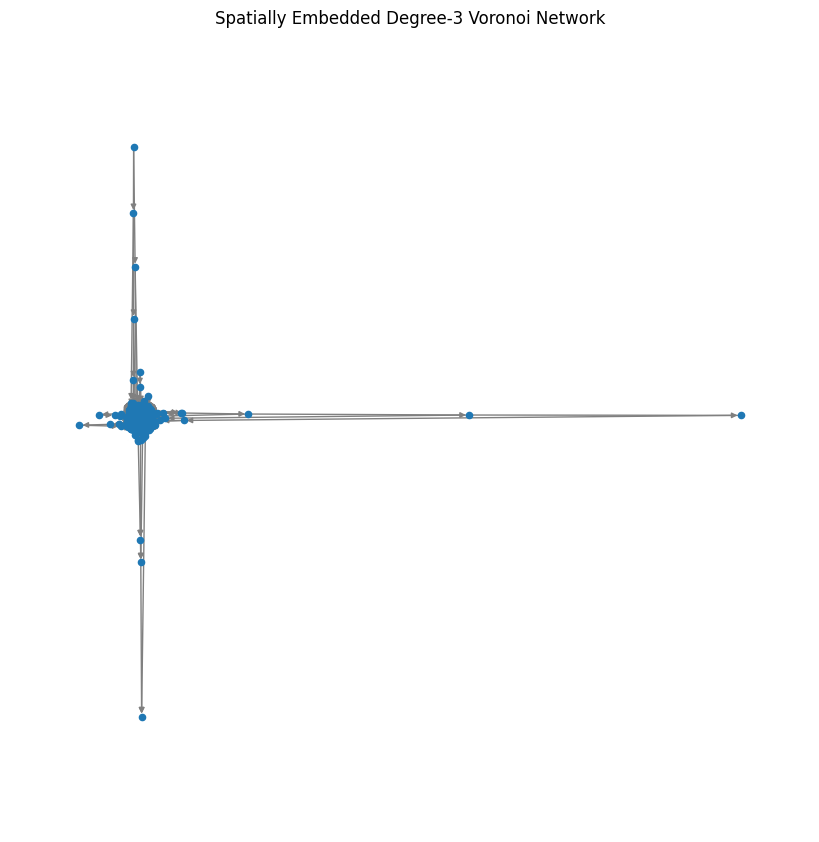

In [4]:
import numpy as np
import scipy.spatial as sp
import networkx as nx
import matplotlib.pyplot as plt

# Rebuild the spatial Voronoi graph and its orientation
np.random.seed(42)
points = np.random.rand(3000, 2)
vor = sp.Voronoi(points)

# Build undirected Voronoi dual
G = nx.Graph()
for i, v in enumerate(vor.vertices):
    G.add_node(i, pos=tuple(v))
for rv in vor.ridge_vertices:
    if rv[0] >= 0 and rv[1] >= 0:
        G.add_edge(rv[0], rv[1])

# Orient edges downward
DG = nx.DiGraph()
for u, v in G.edges():
    y1, y2 = G.nodes[u]['pos'][1], G.nodes[v]['pos'][1]
    if y1 > y2:
        DG.add_edge(u, v)
    elif y2 > y1:
        DG.add_edge(v, u)
    else:
        if np.random.rand() < 0.5:
            DG.add_edge(u, v)
        else:
            DG.add_edge(v, u)

# Filter to nodes of total degree 3
nodes3 = [n for n in DG if DG.in_degree(n) + DG.out_degree(n) == 3]
DG = DG.subgraph(nodes3)

# Plot the network
pos = {n: G.nodes[n]['pos'] for n in DG.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(
    DG,
    pos=pos,
    node_size=20,
    with_labels=False,
    arrowsize=8,
    arrowstyle='-|>',
    edge_color='gray'
)
plt.title('Spatially Embedded Degree-3 Voronoi Network')
plt.axis('equal')
plt.show()


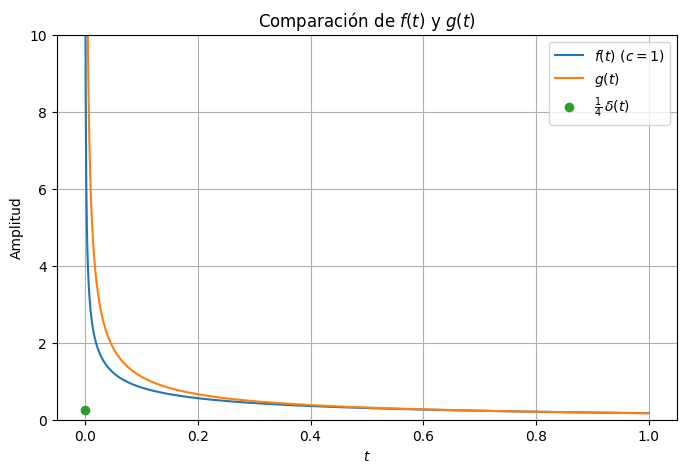

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, gamma

# Parámetro c=1
c = 1.0

# f(t) sin la delta
def f(t):
    term1 = t / (8*c**2)
    term2 = np.exp(-t/(4*c)) / (2*np.sqrt(np.pi*c*t)) * (1 - t/(2*c))
    term3 = - t/(8*c**2) * erf(np.sqrt(t)/(2*np.sqrt(c)))
    return term1 + term2 + term3

# g(t)
def g(t):
    coef = (2/7)**(2/7) / gamma(2/7)
    return coef * t**(-5/7) * np.exp(-2*t/7)

# Muestreo
t_vals = np.linspace(1e-4, 1.0, 2000)
f_vals = f(t_vals)
g_vals = g(t_vals)

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(t_vals, f_vals, label=r'$f(t)\ (c=1)$')
plt.plot(t_vals, g_vals, label=r'$g(t)$')
# Punto para la delta de Dirac en t=0 con peso 1/4
plt.plot(0, 0.25, 'o', label=r'$\frac{1}{4}\,\delta(t)$')
plt.xlabel(r'$t$')
plt.ylabel('Amplitud')
plt.title('Comparación de $f(t)$ y $g(t)$')
plt.legend()
plt.ylim(0,10)
plt.grid(True)
plt.show()
